In [1]:
!pip install kaggle pymorphy2

In [0]:
import json
import os

In [0]:
if not os.path.isdir('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump({"username": "ivkireev", "key": "fd08df0228dd035e267daa48e37cbde7"}, file)

In [0]:
!chmod 600 "/root/.kaggle/kaggle.json"

In [0]:
if not os.path.isdir('data'):
    os.makedirs('data')

In [6]:
!kaggle competitions download -c nlp-workshop-diagnosis-prediction --path data

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# Local

In [0]:
import zipfile

In [0]:
import numpy as np
import pandas as pd

In [0]:
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline

In [0]:
pd.options.display.max_columns = 50

# Read data

In [12]:
with zipfile.ZipFile("data/train.csv.zip") as z:
    names = z.namelist()
    print(f"names: {names}")
    with z.open(names[0]) as f:
        pd_train = pd.read_csv(f, index_col=0)
        
with zipfile.ZipFile("data/test.csv.zip") as z:
    names = z.namelist()
    print(f"names: {names}")
    with z.open(names[0]) as f:
        pd_test = pd.read_csv(f, index_col=0)
        
pd_sample = pd.read_csv("data/sample_submission.csv")

names: ['train.csv']
names: ['test.csv']


In [13]:
pd_train.head(2)

,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга
0,115819,54,Гипертензивная болезнь сердца [гипертоническая...,"на повышение ад утром до 140/90 мм.рт.ст., пер...",Другое,5,I11,2,"Прием врача-кардиолога повторный, амбулаторный"
1,399973,32,Доброкачественное новообразование молочной железы,На наличие опухоли в левой молочной железе,Другое,3,D24,2,"Прием врача-онколога (маммолога), повторный, а..."


In [14]:
pd_test.head(2)

,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга
0,598841,43,на момент осмотра не предъявляет,Рекомендации знакомых,5,2,"Прием врача-акушера-гинеколога повторный, амбу..."
1,596613,37,"На слабость, головную боль, на расфокусировку ...",Зарегистрировался на сайте,3,1,"Прием врача-кардиолога повторный, амбулаторный"


In [15]:
pd_sample.head(2)

,index,Код_диагноза
0,0,J06.9
1,1,J06.9


In [16]:
pd_train.shape, pd_test.shape, pd_sample.shape

((49619, 9), (12021, 7), (12021, 2))

# Target

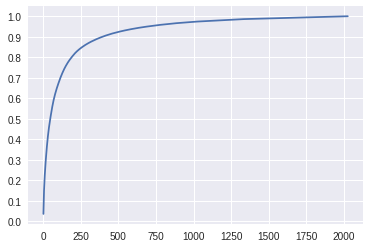

In [17]:
pd_train["Код_диагноза"].value_counts(normalize=True).cumsum().reset_index(drop=True) \
    .plot(grid=True, yticks=np.arange(0, 1.01, 0.1))

In [0]:
target_dict = pd_train["Код_диагноза"].value_counts().reset_index()["index"]
target_dict = target_dict.reset_index().set_index("index")
target_dict.iloc[1200:] = -1
target_dict_code2ix = target_dict['level_0'].to_dict()
target_dict_ix2code = {v: k for k, v in target_dict_code2ix.items() if v >= 0}

In [0]:
pd_train["y"] = pd_train["Код_диагноза"].map(target_dict_code2ix)

In [0]:
X = pd_train.loc[pd_train["y"].ge(0), ["Id_Пациента", "Возраст", "Жалобы", "Источник_рекламы", "Клиника", "Пол", "Услуга"]].copy()
y = pd_train.loc[pd_train["y"].ge(0), "y"].values

In [21]:
X.shape, y.shape

((48681, 7), (48681,))

In [0]:
from sklearn.model_selection import train_test_split
i_train, i_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y)

# Model

In [23]:
import sklearn
sklearn.__version__

'0.20.3'

In [0]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

class StratifiedKFoldTqdm(StratifiedKFold):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def split(self, X, y, groups=None):
        return tqdm_notebook(super().split(X, y, None), total=self.n_splits)    
        
cv_skf = StratifiedKFoldTqdm(n_splits=5, random_state=42)

In [0]:
from sklearn.model_selection import cross_val_score

# Features

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

In [0]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.col_name].values

## MorphAnalyzer

In [0]:
from pymorphy2 import MorphAnalyzer

In [0]:
morph = MorphAnalyzer()

In [30]:
morph.parse("раму")

[Parse(word='раму', tag=OpencorporaTag('NOUN,inan,masc,Geox sing,datv'), normal_form='рам', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'раму', 32, 2),)),
 Parse(word='раму', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), normal_form='рама', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'раму', 55, 3),))]

In [0]:
import re

In [0]:
class Normalizer(BaseEstimator, TransformerMixin):
    _cache = {}
    
    @staticmethod
    def _process(line):
        def norm(word):
            if word in Normalizer._cache:
                return Normalizer._cache[word]
            
            n = morph.parse(word)[0].normal_form
            Normalizer._cache[word] = n
            
            return n
        
        return " ".join([norm(word) for word in re.findall(r"\w+", line.lower())])
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self._process(line) for line in X])

In [33]:
Normalizer().fit_transform(["Мама мыла- раму", "Папа чинил сапоги"])

array(['мама мыло рам', 'папа чинить сапог'], dtype='<U17')

## Услуга

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
pipe_service = Pipeline([
    ('select', ColumnSelector("Услуга")),
    ('norm', Normalizer()),
    ('tfidf', TfidfVectorizer()),
])

In [36]:
%%time
# pipe_service.set_params(tfidf__token_pattern=r"\b\w{,5}")
X_service = pipe_service.fit_transform(X)

CPU times: user 735 ms, sys: 18.2 ms, total: 754 ms
Wall time: 763 ms


In [37]:
X_service.shape

(48681, 241)

In [38]:
pipe_service.named_steps["tfidf"].vocabulary_

{'001': 0,
 '15': 1,
 '18': 2,
 '28': 3,
 'air': 4,
 'flow': 5,
 'акушер': 6,
 'акция': 7,
 'аллерголог': 8,
 'амбулаторный': 9,
 'анатомический': 10,
 'ангиохирург': 11,
 'андролог': 12,
 'анестезия': 13,
 'апп': 14,
 'аппарат': 15,
 'аппликационный': 16,
 'бассейн': 17,
 'без': 18,
 'беременный': 19,
 'бесплатный': 20,
 'бесплый': 21,
 'бинокулярный': 22,
 'биомикроскопия': 23,
 'блокада': 24,
 'более': 25,
 'больший': 26,
 'бца': 27,
 'ваш': 28,
 'ведущий': 29,
 'весь': 30,
 'водянка': 31,
 'волновой': 32,
 'восстановление': 33,
 'врач': 34,
 'врачебный': 35,
 'временной': 36,
 'выдача': 37,
 'выписка': 38,
 'гастроэнтеролог': 39,
 'гастроэнтерологический': 40,
 'гибдд': 41,
 'гинеколог': 42,
 'гипсовый': 43,
 'главный': 44,
 'глаз': 45,
 'глазной': 46,
 'гнойный': 47,
 'гомеопатический': 48,
 'гомеосиниатрия': 49,
 'групон': 50,
 'день': 51,
 'дерматовенеролог': 52,
 'детский': 53,
 'диагноз': 54,
 'диагностический': 55,
 'диаметр': 56,
 'динамический': 57,
 'для': 58,
 'дневник': 

## Жалоба

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
pipe_symptom = Pipeline([
    ('select', ColumnSelector("Жалобы")),
    ('norm', Normalizer()),
    ('tfidf', TfidfVectorizer(min_df=4, max_df=0.6, max_features=10000)),
])

In [41]:
%%time
# pipe_service.set_params(tfidf__token_pattern=r"\b\w{,5}")
X_symptom = pipe_symptom.fit_transform(X)

CPU times: user 4.1 s, sys: 63 ms, total: 4.16 s
Wall time: 4.17 s


In [42]:
X_symptom.shape

(48681, 2222)

In [43]:
X_symptom

<48681x2222 sparse matrix of type '<class 'numpy.float64'>'
	with 333441 stored elements in Compressed Sparse Row format>

In [44]:
pipe_symptom.named_steps["tfidf"].vocabulary_

{'повышение': 1349,
 'ада': 106,
 'утром': 2057,
 'до': 466,
 '140': 23,
 '90': 96,
 'мм': 886,
 'рт': 1680,
 'ст': 1850,
 'периодич': 1293,
 'головокружение': 376,
 'наличие': 951,
 'опухоль': 1155,
 'левый': 764,
 'молочный': 894,
 'железо': 510,
 'активный': 112,
 'жалоба': 499,
 'нет': 1032,
 'сохраняться': 1823,
 'боль': 187,
 'спина': 1832,
 'поясница': 1472,
 'скованность': 1761,
 'она': 1136,
 'дискомфорт': 444,
 'горло': 385,
 'слабый': 1771,
 'першение': 1304,
 'слабость': 1769,
 'палец': 1236,
 'правый': 1478,
 'кисть': 661,
 'не': 983,
 'измениться': 596,
 'момент': 895,
 'первое': 1261,
 'приём': 1531,
 'по': 1335,
 'цикл': 2128,
 'паховый': 1255,
 'подвздошный': 1357,
 'область': 1092,
 'фон': 2093,
 'лечение': 772,
 'самочувствие': 1692,
 'улучшение': 2020,
 'болевой': 177,
 'диспептический': 449,
 'синдром': 1749,
 'выразить': 319,
 'аппетит': 132,
 'норма': 1065,
 'переносить': 1275,
 'хорошо': 2114,
 'отмечаться': 1204,
 'положительный': 1418,
 'клинико': 668,
 'эндос

## Клиника

In [45]:
X["Клиника"].value_counts()

3     34436
6      5547
5      5409
2      3128
15      159
19        2
Name: Клиника, dtype: int64

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
pipe_clinic = Pipeline([
    ('select', ColumnSelector(["Клиника"])),
    ('ohe', OneHotEncoder(sparse=False, categories='auto', handle_unknown="ignore")),
])

In [0]:
X_clinic = pipe_clinic.fit_transform(X)

In [49]:
X_clinic.shape

(48681, 6)

In [50]:
X_clinic

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

## Пол

In [51]:
X["Пол"].value_counts()

2    33750
1    14931
Name: Пол, dtype: int64

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
pipe_sex = Pipeline([
    ('select', ColumnSelector(["Пол"])),
    ('ohe', OneHotEncoder(sparse=False, categories='auto', handle_unknown="ignore")),
])

In [0]:
X_sex = pipe_sex.fit_transform(X)

In [55]:
X_sex.shape

(48681, 2)

In [56]:
X_sex

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Возраст

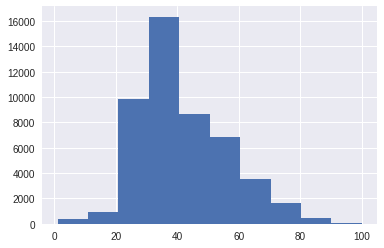

In [57]:
X["Возраст"].clip(0, 100).hist()

In [0]:
class ClipTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.clip(X, 0, 100)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
pipe_age = Pipeline([
    ('select', ColumnSelector(["Возраст"])),
    ('clip', ClipTransformer()),
    ('norm', MinMaxScaler()),
])

In [61]:
X_age = pipe_age.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [62]:
X_age.shape

(48681, 1)

In [63]:
X_age

array([[0.53535354],
       [0.31313131],
       [0.71717172],
       ...,
       [0.67676768],
       [0.29292929],
       [0.24242424]])

## Источник_рекламы

In [64]:
X["Источник_рекламы"].value_counts()

Другое                                 29031
Интернет                                8586
Рекомендации знакомых                   7053
Зарегистрировался на сайте              1263
Живет-работает рядом                     842
Страховая                                420
Щиты,уличная реклама                     389
Рекомендации к доктору                   318
Кутузовский                              158
Гефест                                   115
Врач Бегма Андрей Николаевич              49
Листовки                                  33
Кунцево                                   30
дельта                                    23
не назвала                                23
ДМС                                       21
ООО Дельта                                21
Врач Суван-оол Марина Анатольевна         20
Уклеина Наталья Григорьевна               15
Радио                                     14
Сайт ИП Веревошников                      14
МедЭлит                                   13
Врач Чабан

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
pipe_adv = Pipeline([
    ('select', ColumnSelector(["Источник_рекламы"])),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore")),
])

In [0]:
X_adv = pipe_adv.fit_transform(X)

In [68]:
X_adv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
X_adv.shape

(48681, 115)

# NN

In [70]:
import keras
import keras.backend as K
from keras import layers
from keras import Model

Using TensorFlow backend.


In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [0]:
def get_model():
    i_service = layers.Input(shape=(X_service.shape[1],), name="service")
    i_clinic = layers.Input(shape=(X_clinic.shape[1],), name="clinic")

    i_adv = layers.Input(shape=(X_adv.shape[1],), name="adv")
    l_adv = layers.Dense(32, activation="relu")(i_adv)
    l_adv = layers.BatchNormalization()(l_adv)

    i_sex = layers.Input(shape=(X_sex.shape[1],), name="sex")
    i_age = layers.Input(shape=(X_age.shape[1],), name="age")

    i_symptom = layers.Input(shape=(X_symptom.shape[1],), name="symptom")
    l_symptom = layers.Dropout(0.2)(i_symptom)
    l_symptom = layers.Dense(256, activation="relu")(l_symptom)

    h_m1 = layers.concatenate([i_service, i_clinic])
    h_m1 = layers.Dense(64)(h_m1)
    h_m1 = layers.BatchNormalization()(h_m1)
    
    h_m2 = layers.concatenate([i_sex, i_age])
    h_m2 = layers.Dense(64)(h_m2)
    h_m2 = layers.BatchNormalization()(h_m2)
    
    h_merge = layers.concatenate([h_m1, l_adv, h_m2])
    h_merge = layers.Dropout(0.2)(h_merge)
    h_merge = layers.Dense(256, activation="relu")(h_merge)

    h_merge2 = layers.concatenate([h_merge, l_symptom])
    h_merge2 = layers.BatchNormalization()(h_merge2)
    h_merge2 = layers.Dropout(0.2)(h_merge2)
    h_merge2 = layers.Dense(512, activation="relu")(h_merge2)
    h_merge2 = layers.Dropout(0.2)(h_merge2)

    o_diagnosis = layers.Dense(1200, activation="softmax")(h_merge2)

    model = Model(inputs=[i_service, i_clinic, i_adv, i_sex, i_age, i_symptom], outputs=[o_diagnosis])
    
    model.compile(optimizer=keras.optimizers.adam(lr=0.0005 / 2, decay=0.0001),
              metrics=["categorical_accuracy"], loss="categorical_crossentropy")
    
    return model

In [73]:
model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [74]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
service (InputLayer)            (None, 241)          0                                            
__________________________________________________________________________________________________
clinic (InputLayer)             (None, 6)            0                                            
__________________________________________________________________________________________________
sex (InputLayer)                (None, 2)            0                                            
__________________________________________________________________________________________________
age (InputLayer)                (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

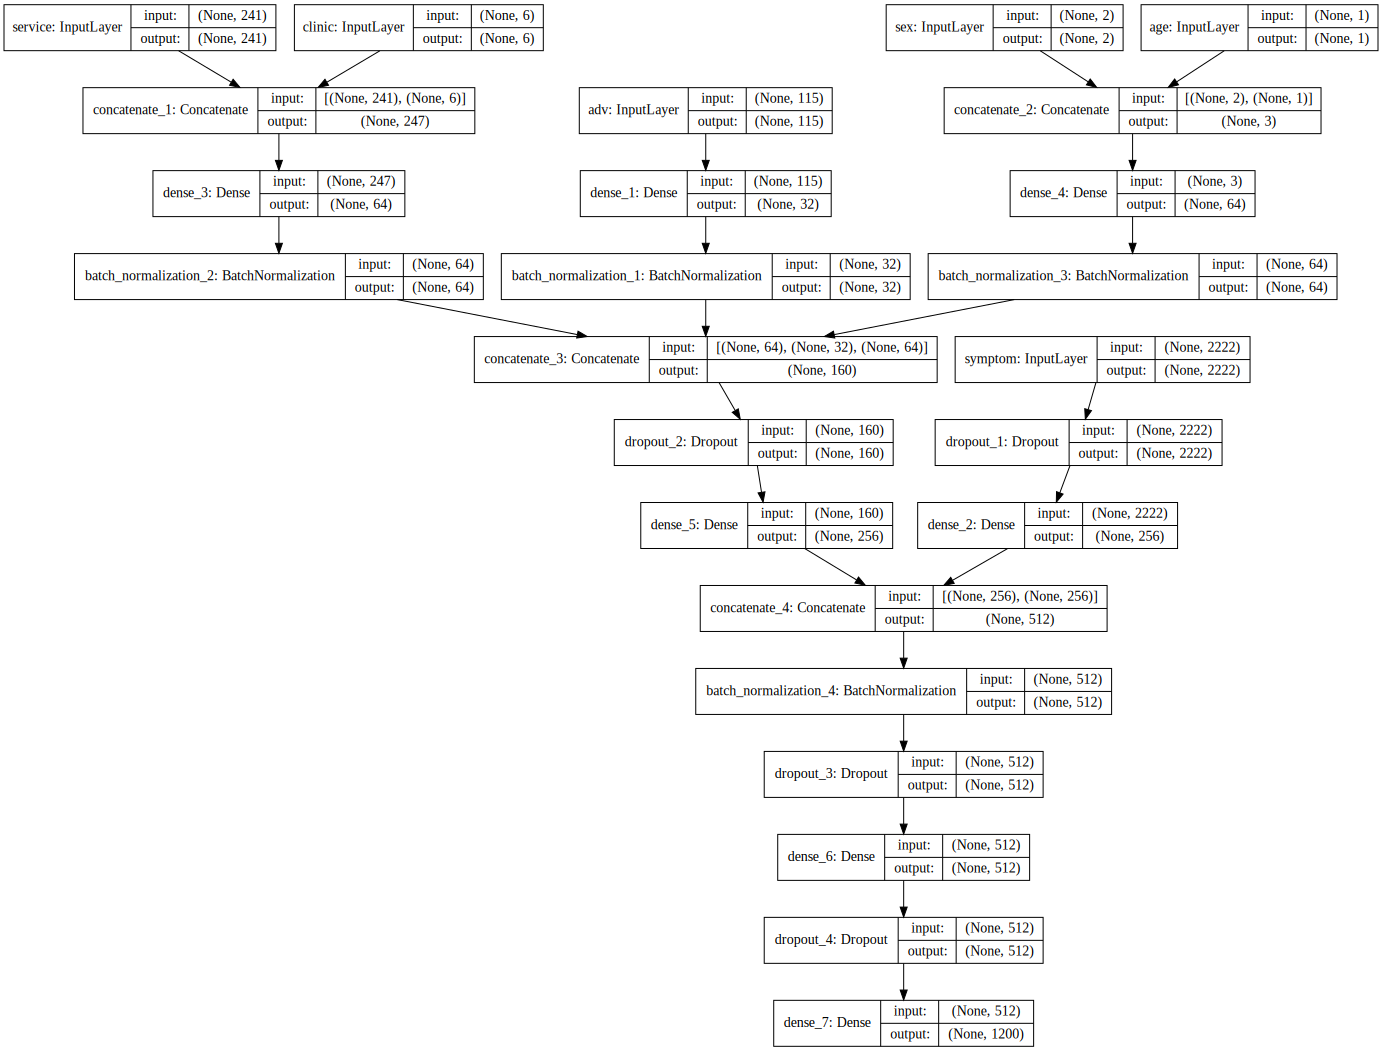

In [75]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
X_input = [X_service, X_clinic, X_adv, X_sex, X_age, X_symptom]

X_train = [m[i_train] for m in X_input]
X_test = [m[i_test] for m in X_input]

y_train = [keras.utils.to_categorical(y)[i_train]]
y_test = [keras.utils.to_categorical(y)[i_test]]

In [77]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=2, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 34076 samples, validate on 14605 samples
Epoch 1/20
 - 7s - loss: 4.3976 - categorical_accuracy: 0.2244 - val_loss: 3.2592 - val_categorical_accuracy: 0.3115
Epoch 2/20
 - 5s - loss: 3.1304 - categorical_accuracy: 0.3156 - val_loss: 2.8694 - val_categorical_accuracy: 0.3456
Epoch 3/20
 - 6s - loss: 2.7821 - categorical_accuracy: 0.3436 - val_loss: 2.6957 - val_categorical_accuracy: 0.3604
Epoch 4/20
 - 6s - loss: 2.5844 - categorical_accuracy: 0.3616 - val_loss: 2.6044 - val_categorical_accuracy: 0.3684
Epoch 5/20
 - 6s - loss: 2.4339 - categorical_accuracy: 0.3788 - val_loss: 2.5544 - val_categorical_accuracy: 0.3734
Epoch 6/20
 - 6s - loss: 2.3121 - categorical_accuracy: 0.3932 - val_loss: 2.5209 - val_categorical_accuracy: 0.3771
Epoch 7/20
 - 5s - loss: 2.2103 - categorical_accuracy: 0.4091 - val_loss: 2.5029 - val_categorical_accuracy: 0.3826
Epoch 8/20
 - 5s - loss: 2.1281 - categorical_accuracy: 0.4224 - val_loss: 2.4936 -

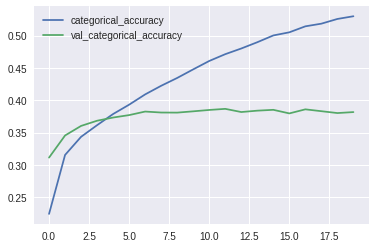

In [78]:
pd.DataFrame(history.history)[["categorical_accuracy", "val_categorical_accuracy"]] \
    .plot(grid=True)

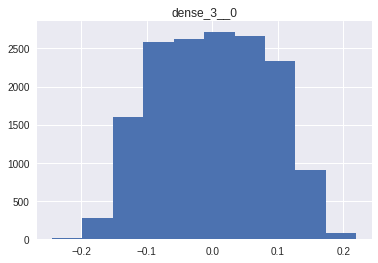

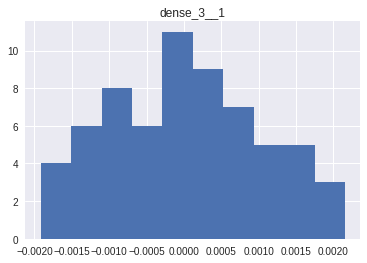

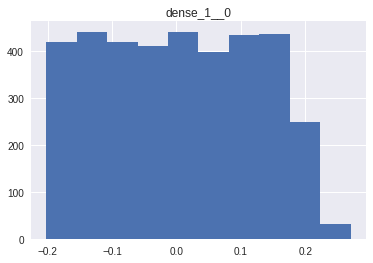

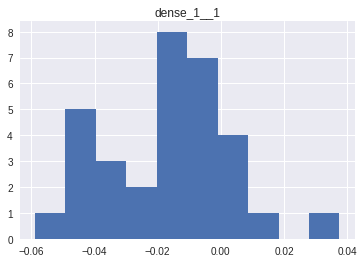

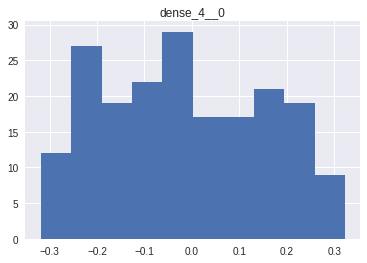

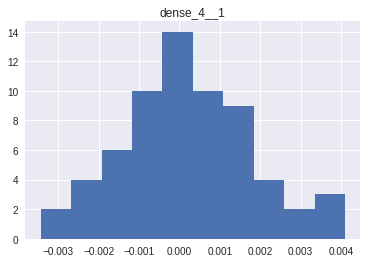

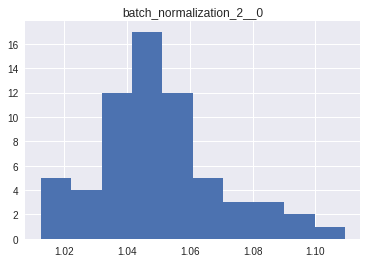

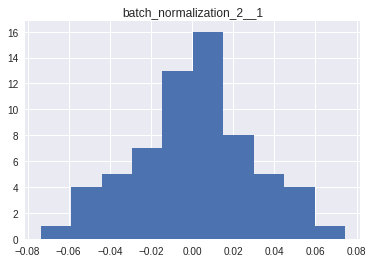

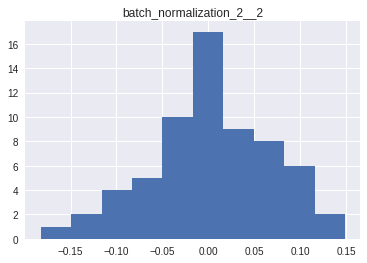

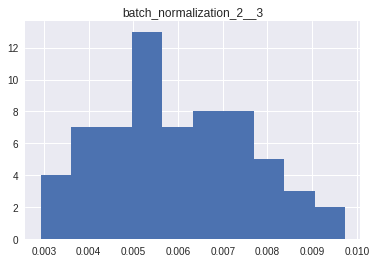

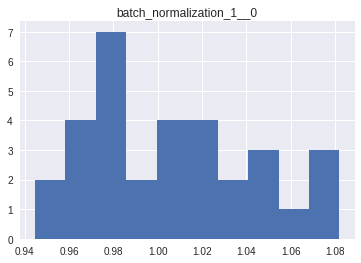

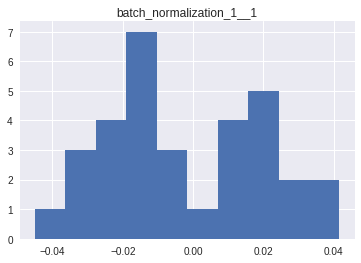

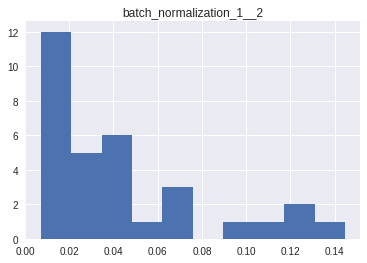

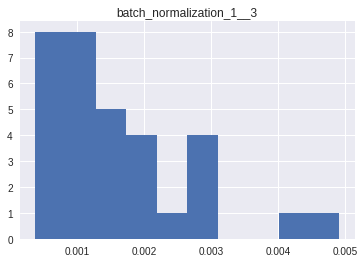

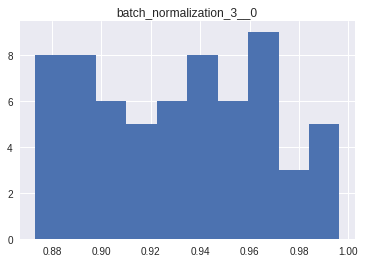

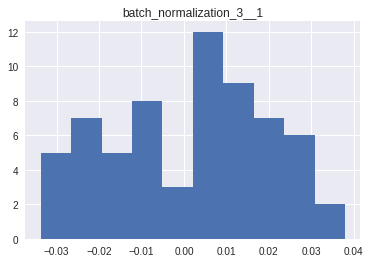

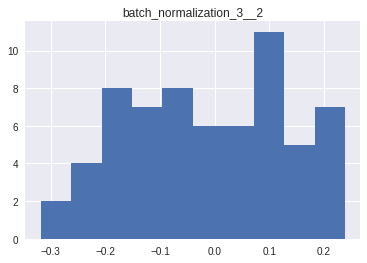

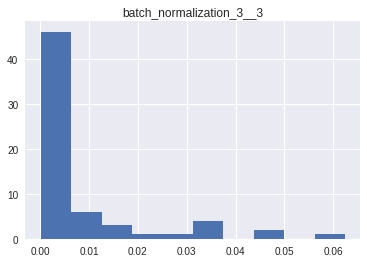

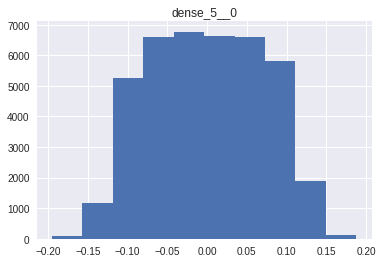

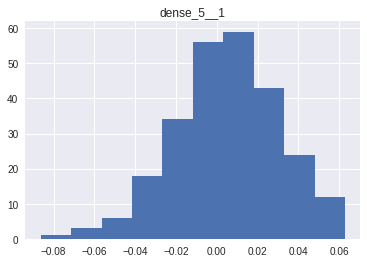

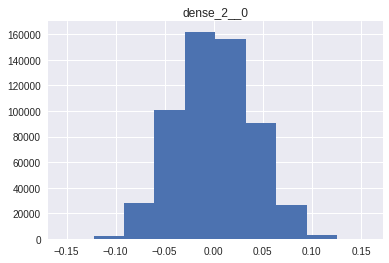

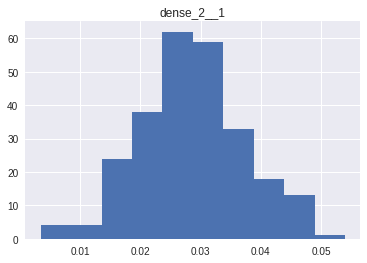

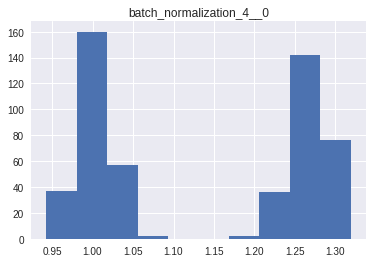

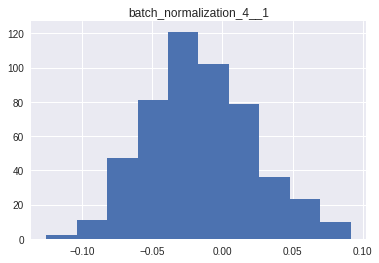

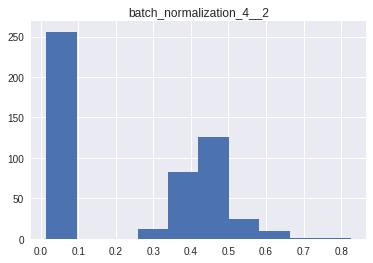

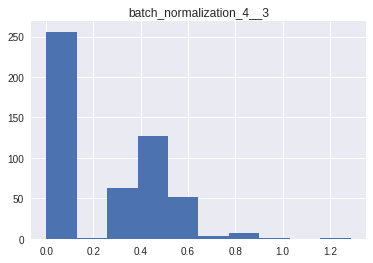

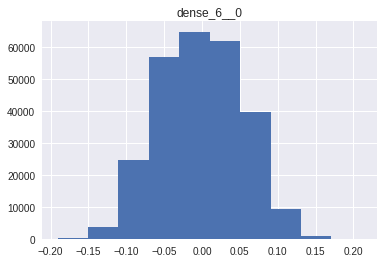

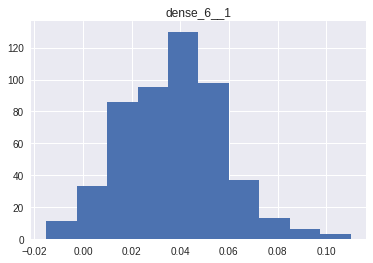

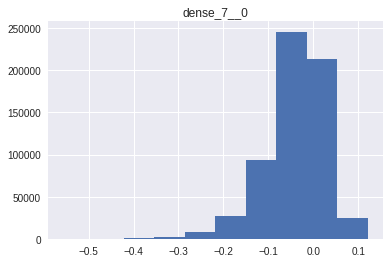

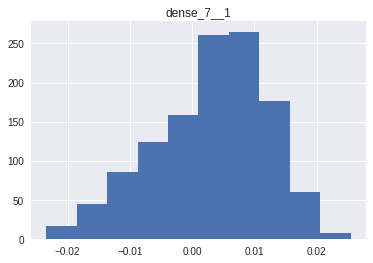

In [79]:
for l in model.layers:
    for i, w in enumerate(l.get_weights()):
        _name = f"{l.name}__{i}"
        plt.hist(w.flatten())
        plt.title(_name)
        plt.show()

# Submit

In [0]:
X_test_inp = [
    pipe_service.transform(pd_test), 
    pipe_clinic.transform(pd_test), 
    pipe_adv.transform(pd_test),
    pipe_sex.transform(pd_test),
    pipe_age.transform(pd_test),
    pipe_symptom.transform(pd_test),
]

In [0]:
model = get_model()

In [82]:
model.fit(X_input, keras.utils.to_categorical(y), batch_size=128, epochs=20, verbose=2)

Epoch 1/20
 - 8s - loss: 4.0693 - categorical_accuracy: 0.2510
Epoch 2/20
 - 7s - loss: 2.9516 - categorical_accuracy: 0.3261
Epoch 3/20
 - 7s - loss: 2.6623 - categorical_accuracy: 0.3516
Epoch 4/20
 - 7s - loss: 2.4882 - categorical_accuracy: 0.3689
Epoch 5/20
 - 7s - loss: 2.3522 - categorical_accuracy: 0.3872
Epoch 6/20
 - 7s - loss: 2.2532 - categorical_accuracy: 0.3998
Epoch 7/20
 - 7s - loss: 2.1709 - categorical_accuracy: 0.4126
Epoch 8/20
 - 7s - loss: 2.0984 - categorical_accuracy: 0.4222
Epoch 9/20
 - 7s - loss: 2.0374 - categorical_accuracy: 0.4315
Epoch 10/20
 - 7s - loss: 1.9822 - categorical_accuracy: 0.4433
Epoch 11/20
 - 7s - loss: 1.9266 - categorical_accuracy: 0.4562
Epoch 12/20
 - 7s - loss: 1.8778 - categorical_accuracy: 0.4643
Epoch 13/20
 - 7s - loss: 1.8509 - categorical_accuracy: 0.4697
Epoch 14/20
 - 7s - loss: 1.8149 - categorical_accuracy: 0.4798
Epoch 15/20
 - 7s - loss: 1.7849 - categorical_accuracy: 0.4851
Epoch 16/20
 - 7s - loss: 1.7508 - categorical_ac

In [0]:
y_predict = model.predict(X_test_inp, batch_size=128)

In [0]:
pd_submit = pd.DataFrame({"index": pd_test.index})
pd_submit["y_predict"] = y_predict.argmax(axis=1)
pd_submit["Код_диагноза"] = pd_submit["y_predict"].map(target_dict_ix2code).fillna(target_dict_ix2code[0])

In [0]:
submit_file_name = "submit_a02.csv"

In [0]:
pd_submit[["index", "Код_диагноза"]].to_csv(submit_file_name, index=None)

In [88]:
!kaggle competitions submit -c nlp-workshop-diagnosis-prediction -f $submit_file_name -m "With small tuning"

100% 125k/125k [00:07<00:00, 17.4kB/s]
Successfully submitted to NLP workshop. Diagnosis prediction